In [1]:
import os
import rasterio as rio
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import glob
import random


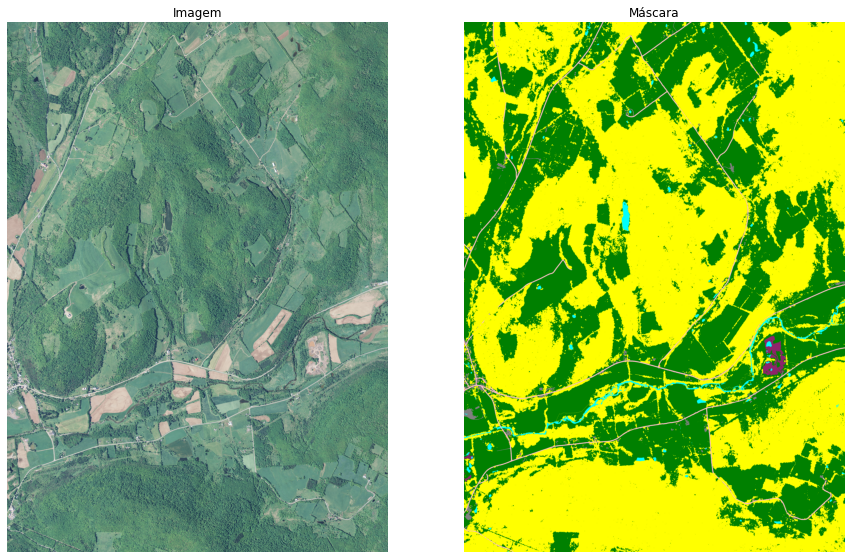

In [6]:
# with rio.open("/scratch/dataset/chesapeake/ny_1m_2013_extended-debuffered-train_tiles/m_4207531_sw_18_1_naip-new.tif") as src:
#     print(src.width, src.height)
#     print(src.crs)
#     print(src.transform)
#     print(src.count)
#     print(src.indexes)

#     red = src.read(1)  # Primeira banda
#     green = src.read(2)  # Segunda banda
#     blue = src.read(3)  # Terceira banda

# # Empilhar as bandas em um array (altura, largura, canais)
# rgb = np.dstack((red, green, blue))

# # Plotar a imagem RGB
# plt.figure(figsize=(10, 10))
# plt.imshow(rgb)
# plt.axis('off')  # Esconder os eixos
# plt.show()

# Função para ler e empilhar bandas RGB
def read_rgb_image(filepath):
    with rio.open(filepath) as src:
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
        rgb = np.dstack((red, green, blue))
    return rgb


colors = [
    'whie',    # 0 - não existe
    'cyan',    # 1 - agua
    'yellow',  # 2 - floresta
    'green',   # 3 - campo
    'black',   # 4 - terra estéril
    'grey',    # 5 - impermeável (outro)
    'pink',    # 6 - impermeável (estrada)
    'black'    # 15 - sem dados
    # Adicione mais cores se tiver mais valores
]

mask_palette = {
    0: (0, 0, 0),        # não existe no dataset
    1: (0, 255, 255),    # agua
    2: (255, 255, 0),    # floresta
    3: (0, 128, 0),      # campo
    4: (142,35,107),     # terra estéril
    5: (128, 128, 128),  # impermeável (outro)
    6: (255, 192, 203),  # impermeável (estrada)
    15: (0, 0, 0)        # sem dados
}

# Cria um dicionário para mapear índices para cores RGB
index_to_color = {index: color for index, color in mask_palette.items()}

def convert_mask(np_mask):
    height, width, channels = np_mask.shape

    # Assume que o primeiro canal é o índice da classe
    class_channel = np_mask[:, :, 0]
    new_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Mapeia os valores do primeiro canal para cores
    for index, color in index_to_color.items():
        new_mask[class_channel == index] = color
    
    return new_mask

# Crie o colormap e o norm
cmap = ListedColormap(colors)
bounds = list(range(len(colors)))  # Se você tiver valores de 0 a 6, ajuste conforme necessário
norm = BoundaryNorm(bounds, cmap.N, clip=True)
img_path = ""
mask_path = ""
# Ler as duas imagens
base_path = "/scratch/gabrielamarante/dataset/ny_1m_2013_extended-debuffered-train_tiles/"
rgb_image = read_rgb_image(base_path + "m_4207442_ne_18_1_naip-new.tif")
mask_image = rio.open(base_path + "m_4207442_ne_18_1_lc.tif").read()
# print(np.unique(mask_image, return_counts=True))
mask_image = convert_mask(np.moveaxis(mask_image, 0, -1))
# Criar a figura e subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# Exibir a primeira imagem
ax1.imshow(rgb_image)
ax1.set_title('Imagem')
ax1.axis('off')

ax2.imshow(mask_image, cmap=cmap, norm=norm)
ax2.set_title('Máscara')
ax2.axis('off')

# Mostrar a figura com as duas imagens lado a lado
plt.show()

In [2]:
base_path = "/scratch/gabrielamarante/dataset/ny_1m_2013_extended-debuffered-train_tiles/"
img_list = glob.glob(base_path + "*lc.tif")

## Gerando arquivos de pools

In [5]:
for mask_image in img_list:
    mask_rast = rio.open(mask_image.replace("naip-new.tif", "lc.tif"))
    
    width = mask_rast.width
    height = mask_rast.height
    
    for i in range(0, width, 400):
        for j in range(0, height, 400):
            window = Window(i, j, 400, 400)
            mask = mask_rast.read(1, window=window)
            # print(np.unique(mask, return_counts=True))
            if mask.shape == (400, 400) and os.path.exists(mask_image.replace( "lc.tif", "naip-new.tif")):
                uniques, counts = np.unique(mask, return_counts=True)
                counts = counts/(400*400)

                for cls, qntd in zip(uniques, counts):
                    if qntd >= 0.1:
                        # print(cls)
                        with open(f"{cls}.txt", 'a') as file:
                            file.write(mask_image + ";" + str(i) + "," + str(j)+"\n")


In [4]:
for i in range(1,7):
    with open(f"{i}.txt", 'r') as file:
        for line in file:
            data = line.strip()
            path, dims = data.split(";")
            dims = dims.split(",")
            print(dims)
            window = Window(dims[0], dims[1],400,400)

['1600', '2800']
['4000', '5600']
['4000', '6000']
['1200', '2800']
['1600', '3200']
['2000', '3200']
['2800', '2000']
['3200', '800']
['400', '5200']
['800', '5200']
['1200', '4400']
['1200', '4800']
['0', '0']
['0', '400']
['0', '800']
['0', '1200']
['0', '1600']
['0', '2000']
['0', '2400']
['0', '2800']
['0', '3200']
['0', '3600']
['0', '4000']
['0', '4400']
['0', '4800']
['0', '5200']
['0', '5600']
['0', '6000']
['400', '0']
['400', '400']
['400', '800']
['400', '1200']
['400', '1600']
['400', '2000']
['400', '2400']
['400', '2800']
['400', '3200']
['400', '3600']
['400', '4000']
['400', '4400']
['400', '4800']
['400', '5200']
['400', '5600']
['400', '6000']
['800', '0']
['800', '400']
['800', '800']
['800', '1200']
['800', '1600']
['800', '2000']
['800', '2400']
['800', '2800']
['800', '3200']
['800', '3600']
['800', '4000']
['800', '4400']
['800', '4800']
['800', '5200']
['800', '5600']
['800', '6000']
['1200', '0']
['1200', '400']
['1200', '800']
['1200', '1200']
['1200', '1600'

In [6]:
for i in range(1,7):
    with open(f"{i}.txt", 'r') as file:
        for line in file:
            try:
                data = line.strip()
                path, dims = data.split(";")
                dims = dims.split(",")
                window = Window(int(dims[0]), int(dims[1]), 400, 400)
                rio.open(path).read(window=window)
                rio.open(path.replace( "lc.tif", "naip-new.tif")).read(window=window)
            except Exception as e:
                print(f"Erro ao abrir o arquivo '{path}': {e}")

KeyboardInterrupt: 